## Background: 

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.


## Objective: 

To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

## Key Questions:

1. How many different segments of customers are there?<br>
2. How are these segments different from each other?<br>
3. What are your recommendations to the bank on how to better market to and
service these customers?


## Data Description:

Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.


- Customer key - Identifier for the customer
- Average Credit Limit - Average credit limit across all the credit cards
- Total credit cards - Total number of credit cards
- Total visits bank - Total number of bank visits
- Total visits online - total number of online visits
- Total calls made - Total number of calls made by the customer

#### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import sklearn.metrics

from sklearn.model_selection  import train_test_split
from sklearn.cluster import KMeans
from scipy.stats import zscore

# Supressing the warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the xlsx file into pandas dataframe
mydata = pd.read_excel('Credit Card Customer Data.xlsx', index_col='Sl_No')  

In [3]:
mydata.head()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
1,87073,100000,2,1,1,0
2,38414,50000,3,0,10,9
3,17341,50000,7,1,3,4
4,40496,30000,5,1,1,4
5,47437,100000,6,0,12,3


- clustering methods are sensitive to imbalanced data, later on we will scale the features before running the models
- Customer Key can be removed as it is equivalent to a ID column

In [4]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 1 to 660
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 36.1 KB


- all datatypes are integers, which is perfect for clustering models because they only take numerical values

In [5]:
dup_mydata = mydata.groupby('Customer Key').count()
print('There are',dup_mydata.loc[dup_mydata.Total_calls_made >=2].shape[0], 'duplicate entries for Customer Key')

for k in list(dup_mydata.loc[dup_mydata.Total_calls_made >=2].index):
    display(mydata.loc[mydata['Customer Key'] == k])

There are 5 duplicate entries for Customer Key


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
49,37252,6000,4,0,2,8
433,37252,59000,6,2,1,2


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
5,47437,100000,6,0,12,3
333,47437,17000,7,3,1,0


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
412,50706,44000,4,5,0,2
542,50706,60000,7,5,2,2


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
392,96929,13000,4,5,0,0
399,96929,67000,6,2,2,2


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
105,97935,17000,2,1,2,10
633,97935,187000,7,1,7,0


#### We can see that the behaviour activity for each of these customers changes quite a lot:

- customer: 47437 started with Avg_Credit_Limit	 100000 then got reducued to 17000; Total_visits_online also fluctuated significantley from 12 visits to 1 visit.

- I don't want to run through each differences in activity for eash customer, but as you can see, customer traits can change over time. It's something to be aware of when concluding results and advising on strategy. There are other factors in play here, but based on the limited dataset at our disposal we cannot draw concrete reasons for why these changes took place.

#### Drop the customer key as we wont be using these in analysis or for running clustering models; also serves no real purpose

In [6]:
mydata.drop('Customer Key', axis=1, inplace=True)

In [7]:
pd.DataFrame(mydata.nunique(),columns=['total unique'])

,total unique
Avg_Credit_Limit,110
Total_Credit_Cards,10
Total_visits_bank,6
Total_visits_online,16
Total_calls_made,11


In [8]:
mydata.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


In [9]:
print('Number of missing values in dataset:',mydata.isnull().sum().sum())

Number of missing values in dataset: 0


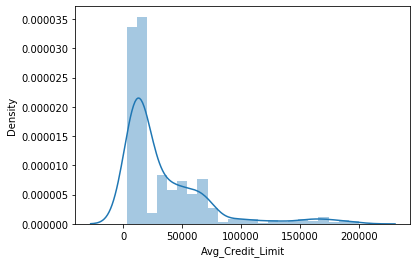

In [10]:
sns.distplot(mydata['Avg_Credit_Limit']);

**Average credit limit:**

- the majority of records do not have credit or have a low limit.

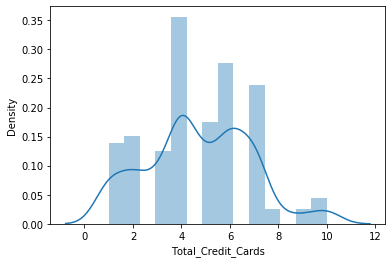

In [11]:
sns.distplot(mydata['Total_Credit_Cards']);

**Total credit cards:**

- looks to be normally distributed. 
- many users have more than one credit card



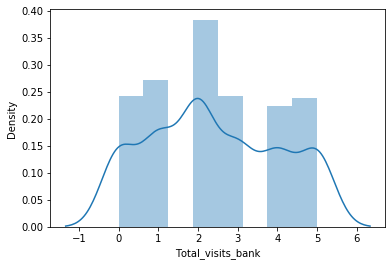

In [12]:
sns.distplot(mydata['Total_visits_bank']);

**Total bank visits:**

- normally distributed variable.
- so it's clear that people still visit banks, but not sure how this model will look in light of a pandemic and the future of high street banking post pandemic

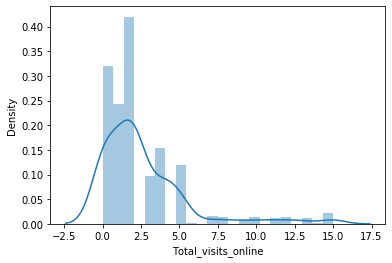

In [13]:
sns.distplot(mydata['Total_visits_online']);

**Total online visits**

- most people visited onine less than 2 times, which could indicated that online service is meeting the needs of the customer as they do not need to keep returning
- after 5, the number of visits made drops significantly

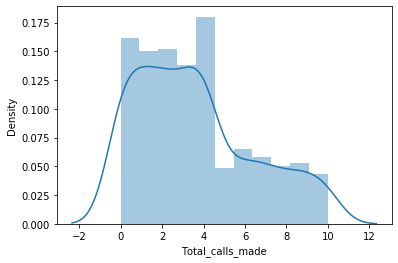

In [14]:
sns.distplot(mydata['Total_calls_made']);

**Total calls made by the customer:**

- lots of calls made more than once, but more than halves after 4 calls
- all these calls could indicate poor customer service as they aren't able to solve the issue on one call

In [15]:
# print(mydata.describe())
pd.DataFrame(mydata.describe().T)

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


#### Histograms

- **Avg_Credit_Limit** right skewed; lot more customers on lower credit limits
- **Total_Credit_Cards** faily normally distributed, most customers hold 4 or more credit cards
- **Total_calls_made** right skewed; majority of customers made upto 4 calls
- **Total_visits_bank** normally distributed; a high number of customers still visit physical branches
- **Total_visits_online** right skewed; a lot more customers go online and use it a lot less that physical branches


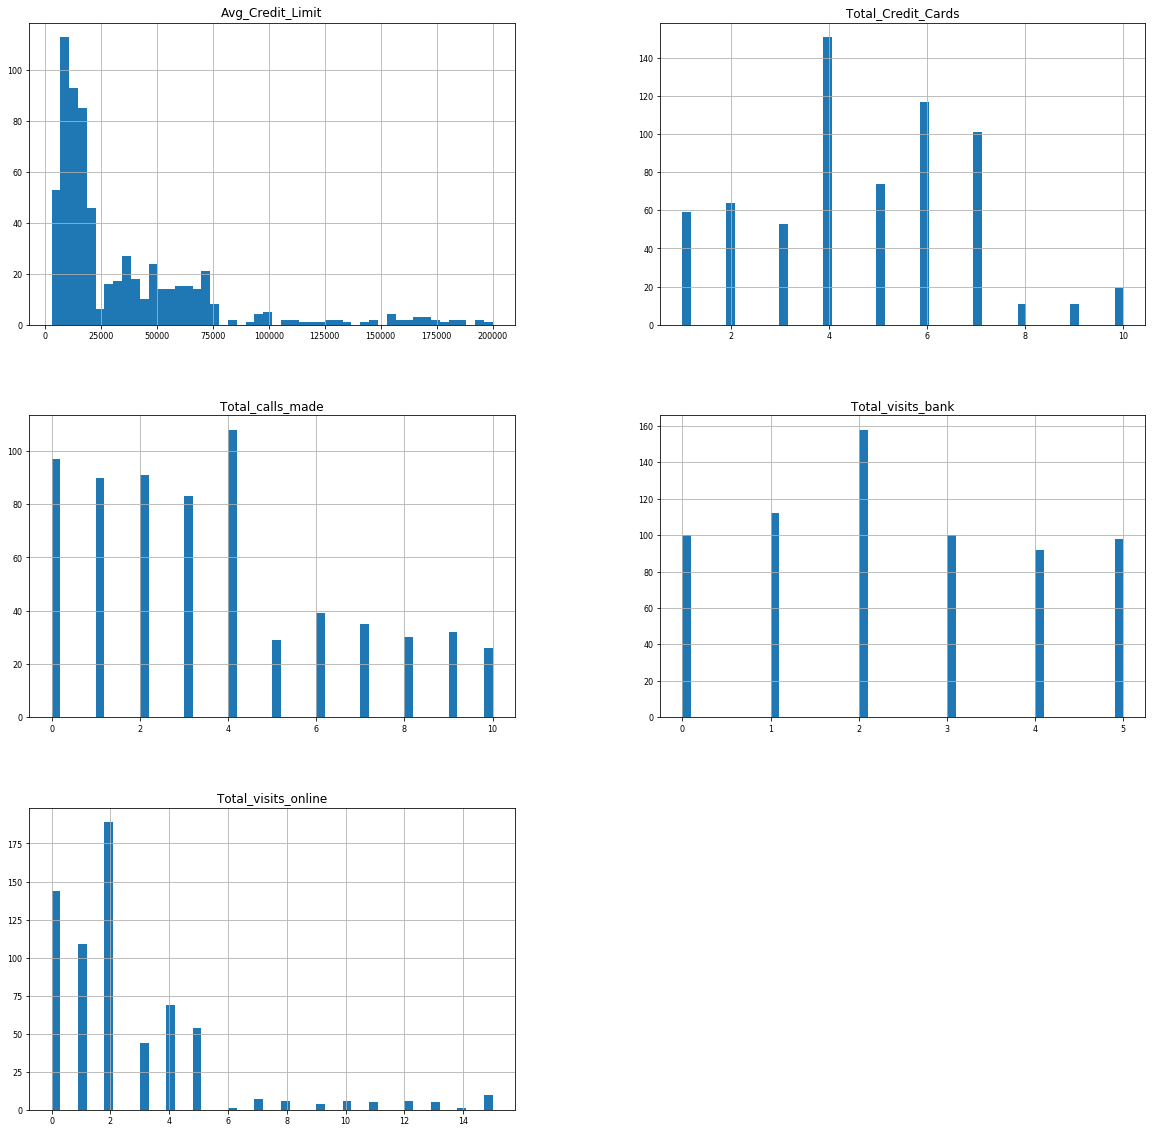

In [16]:
mydata.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

#### Boxplots
Box plots can be useful in understanding data in terms of thecentral tendency and spread.

- they all have outliers
- the distribution for Avg_Credit_Limit is very wide
- no extreme outliers, apart from Avg_Credit_Limit, which has a lot of outliers. But this is due to the continous nature of the variable and there isn't any outlier that is so far out from the rest. So context is everything.
- the median's are more or less in the center at the interquartle ranges

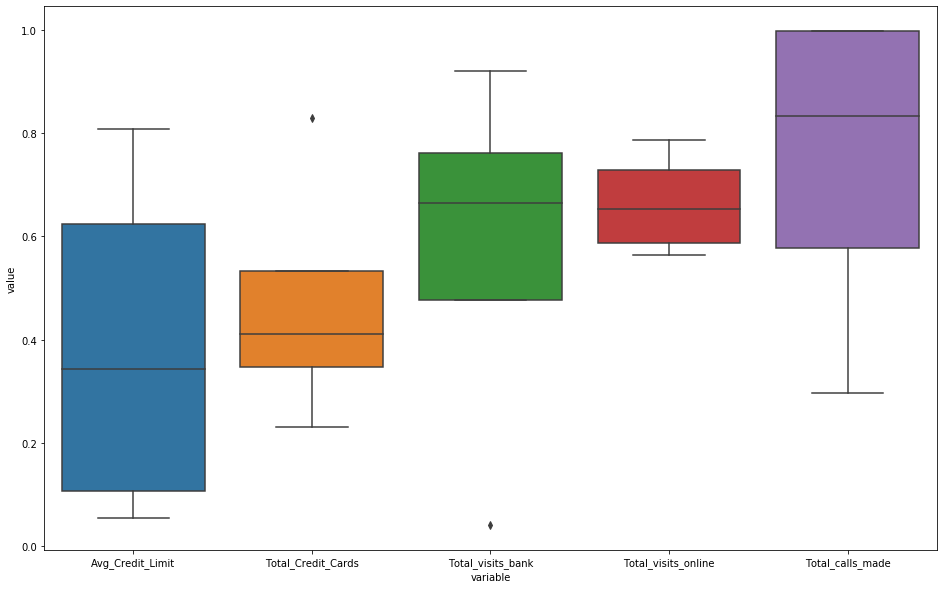

In [17]:
boxData = mydata.copy()

boxData = pd.DataFrame(data = np.random.random(size=(4,5)), columns = ['Avg_Credit_Limit','Total_Credit_Cards','Total_visits_bank','Total_visits_online','Total_calls_made'])
plt.figure(figsize=(16, 10))
sns.boxplot(x="variable", y="value", data=pd.melt(boxData))

plt.show()

**The K-means clustering algorithm is sensitive to outliers, because a mean is easily influenced by extreme values, however, we will not remove them due to the fact that they construct a realistic view of the data. We will also be scaling the data beforehand**

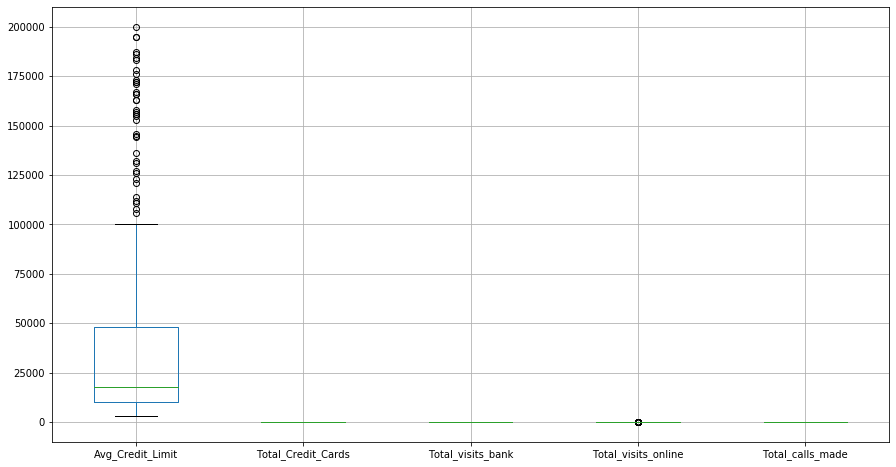

In [18]:
mydata.boxplot(figsize = (15,8))

**Correlation is when the change in one variable results in the change in another variable**

The correlation coefficient is a dimensionless metric and its value ranges from -1 to +1. 

The closer it is to +1 or -1, the more closely the two variables are related. 

If there is no relationship at all between two variables, then the correlation coefficient will certainly be 0. However, if it is 0 then we can only say that there is no linear relationship. There could exist other functional relationships between the variables.

When the correlation coefficient is positive, an increase in one variable also increases the other. When the correlation coefficient is negative, the changes in the two variables are in opposite directions.



In [19]:
mydata.corr()  # prints the correlation coefficient between every pair of attributes

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.608860,-0.100312,0.551385,-0.414352
Total_Credit_Cards,0.608860,1.000000,0.315796,0.167758,-0.651251
Total_visits_bank,-0.100312,0.315796,1.000000,-0.551861,-0.506016
Total_visits_online,0.551385,0.167758,-0.551861,1.000000,0.127299
Total_calls_made,-0.414352,-0.651251,-0.506016,0.127299,1.000000


- some correlation between Avg_Credit_Limit and Total_Credit_Cards; this one is obvious because a person with high credit score can hold more cards and with higher limits.
- some correlataion here between Avg_Credit_Limit and Total_visits_online. 


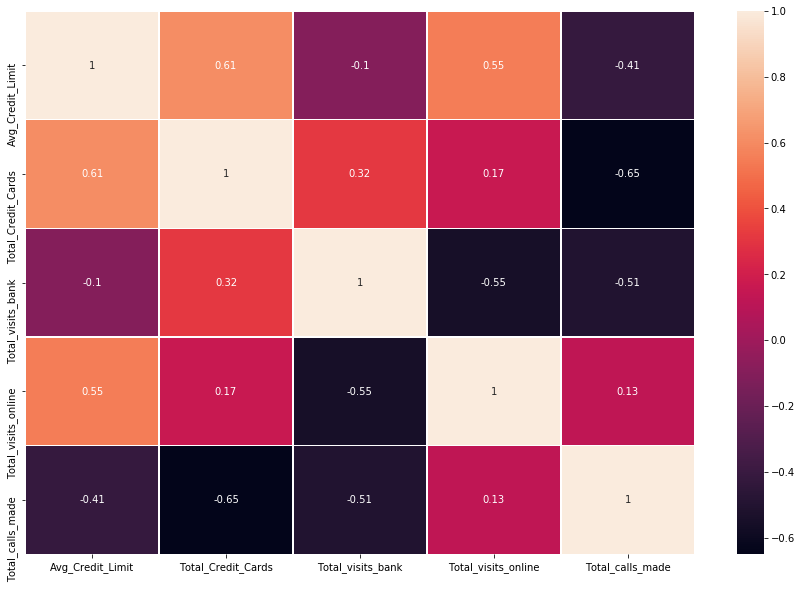

In [20]:
corr = mydata.corr()
plt.figure(figsize = (15,10))
sns.heatmap(corr, annot = True, linewidths=.5)

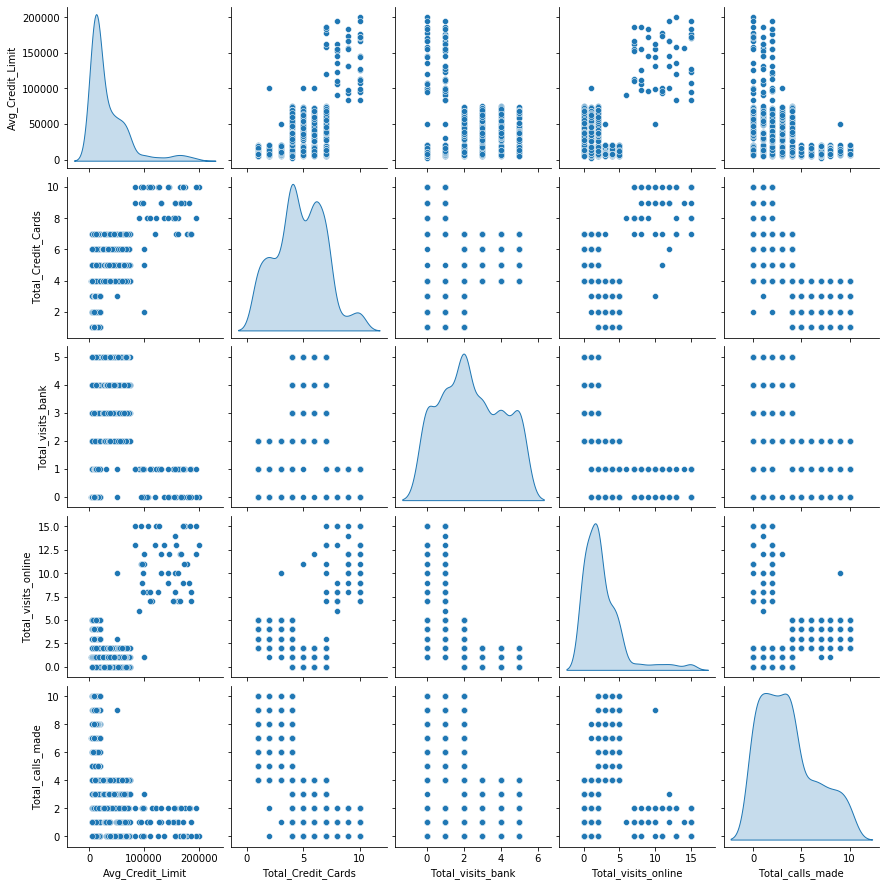

In [21]:
import seaborn as sns
sns.pairplot(mydata, diag_kind='kde') 

**There seems to be some linearity between:** 

- Total Visits Online and Average Credit Limit
- Total Visits Online and Total Credit Cards
- Average Credit Limit and Total Credit Cards

## Unsupervised learning

Unsupervised learning is the different type of machine learning algorithm specially used when the target variable is absent in dataset or the dataset is not labelled. The primary goal of unsupervised learning is find hidden pattern exist within the data. This can be achieved through grouping the data points into homogenous groups also known as clusters. Unsupervised learning is much harder and complex than supervised learning as the results are hard to define in the absence of target variable or labels. The other issue with unsupervised learning is the definition of objective function. Despite these issues unsupervised (clustering) is used to gain the insight of data before applying a classification model. 

## Clustering

Clustering is one of fundamental problem of unsupervised learning algorithm defined as the process of dividing the simple data points into homogeneous groups of similar data points. Grouping of data points is based on the similarities and dissimilarities between them, the points within same group are similar and among different groups they are dissimilar.

This could be understood by following figure where similar data points are clustered on the basis of colour.

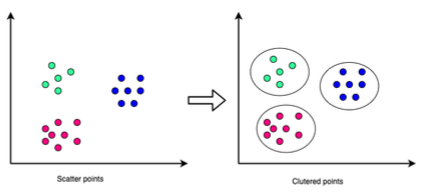

The two methods of clustering I will use in the following examples will be the:

1) K-Means Clustering

2) Hierarchial Clustering

## Scaling the data

- It is important to know that clustering relies on distancing methods and thereit is important to scale the data as a pre-processing step to ensure all the data is of the same scale in terms of the range.

- Most distance measures are highly influenced by the scale of each variable.

- Variables with large scales have a much greater influence over the distance.

- Hence all measurements are converted to the same scale. For example z-scores.

In [22]:
# Before scaling
mydata.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,
1,100000,2,1,1,0
2,50000,3,0,10,9
3,50000,7,1,3,4
4,30000,5,1,1,4
5,100000,6,0,12,3


In [23]:
##Scale the data by Jyoti
from scipy.stats import zscore
mydata_z = mydata.apply(zscore)

In [24]:
# After scaling
mydata_z.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,
1,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
2,0.410293,-0.787585,-1.473731,2.520519,1.891859
3,0.410293,1.058973,-0.860451,0.134290,0.145528
4,-0.121665,0.135694,-0.860451,-0.547490,0.145528
5,1.740187,0.597334,-1.473731,3.202298,-0.203739


## 1) K-means clustering | elbow plot | analysis of clusters using boxplot

Steps taken are:

1) Assume K Centroids

2) Compute Squared Eucledian distance of each objects with these K centroids. Assign each to the closest centroid forming clusters.

3) Compute the new centroid (mean) of each cluster based on the objects assigned to each clusters.

4) Repeat 2 and 3 till convergence: usually defined as the point at which there is no movement of objects between clusters


K-means clustering is a unsupervised learning algorithm whose goal is to find groups or assign the data points to clusters on the basis of their similarity. Which means the points in same cluster are similar to each other and in different clusters are dissimilar with each other. It was developed by researcher named James Macqueen in 1967. Here K means the number of clusters.

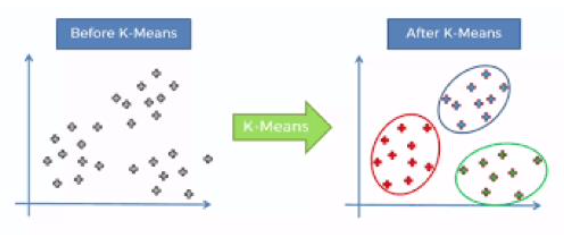

The above figure is showing the working of K-means clustering. Left part is showing the data points before applying the K-means whereas the right part is depicting the situation after the clustering. (data points are grouped into clusters. K-means clustering is very useful and beneficial when most of the data is in unorganized manner. Before moving forward let define some terminology.

**Cluster -** is a collection of the given data points accumulated together because of certain similarities between them.

**Centroid -** It can be termed as a real or imaginary location which represents the centre of the cluster.

**Parameter K -** K is a target variable which refers to the number of centroids in the respective or given dataset. It is used to label the new data.

**Means-** In K-means clustering, ‘means’ refer to the averaging of data used to find the centroid in a the cluster.

The working of K-means clustering is depends on the distance metrics, which are used to find the similarity within data points. The popular distance metric are:

**Euclidean Distance-**
It is the most commonly used distance metrics and defined as the square root of the sum of squared differences between the two points. Let the two points are P (x1, y1) and Q (x2, y2) the Euclidean distance is given by:

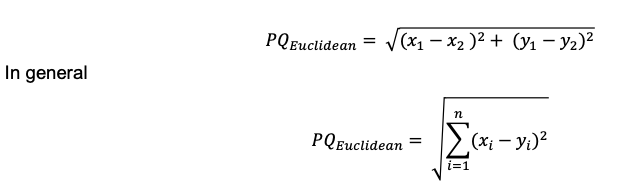

**Working of K-means Clustering -** The working of k-means clustering can be summarized as: 

Step 1- Initialize the K random centroids or k points.(There can be two strategy for it.)
   
   i. Pick random data points and consider those as starting points.
    
   ii. Choose K random values for each particular variable.

Step 2- For each data point calculate the distance of it from randomly chosen K centroid 𝐶𝑖 and assign each point to minimum distance cluster.
  
Step 3- Update the centroid by using newly assigned data points to the cluster by calculating the average of data points.

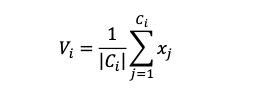

Where 𝑥 data points within cluster 𝐶 and 𝑉 is vector for centroid 𝐶 . 𝑗𝑖𝑖𝑖

Step 4- Repeat the above process for a given no. of iterations or until the centroid allocation no longer changes.

The algorithm is said to be converged once there are no more changes in the values of centroids.

**Objective of clustering -**
The objective of clustering is to minimize the distance between data points and its centroid, 

### Elbow method
It is most popular and well-known method to find the optimal no. of clusters or the value of k in the process of clustering. This method is based of plotting the value of cost function against different values of k. As the number of clusters (k) increase lesser number of points fall within clusters or around the centroids. Hence the average distortion decreases with the increase of number of clusters. The point where the distortion declines most is said to be the elbow point and define the optimal number of clusters for dataset.

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

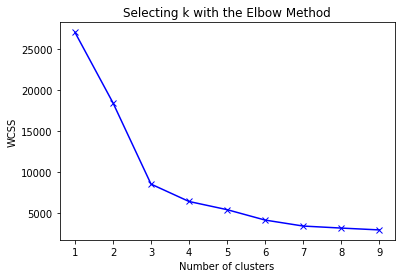

In [25]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist

clusters=range(1,10)
meanDistortions=[]
# score=[]


for k in clusters:
    final_model=KMeans(n_clusters=k)
    final_model.fit(mydata)
    prediction=final_model.predict(mydata)
    meanDistortions.append(sum(np.min(cdist(mydata, final_model.cluster_centers_, 'euclidean'), axis=1)) / mydata.shape[0])
    

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Selecting k with the Elbow Method')

As it is clear from above figure, the distortion declines most at 3. Hence the optimal value of k will be 3 for performing the clustering. In other words the plot looks as an arm with an elbow at k = 3.

### Silhouette Score/Coefficient

Silhouette is a different method to determine optimal number of clusters for given dataset. It defines as a coefficient of measure of how similar an observation to its own cluster compared to that of other clusters. 

Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

1: Means clusters are well apart from each other and clearly distinguished.
0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.

-1: Means clusters are assigned in the wrong way.

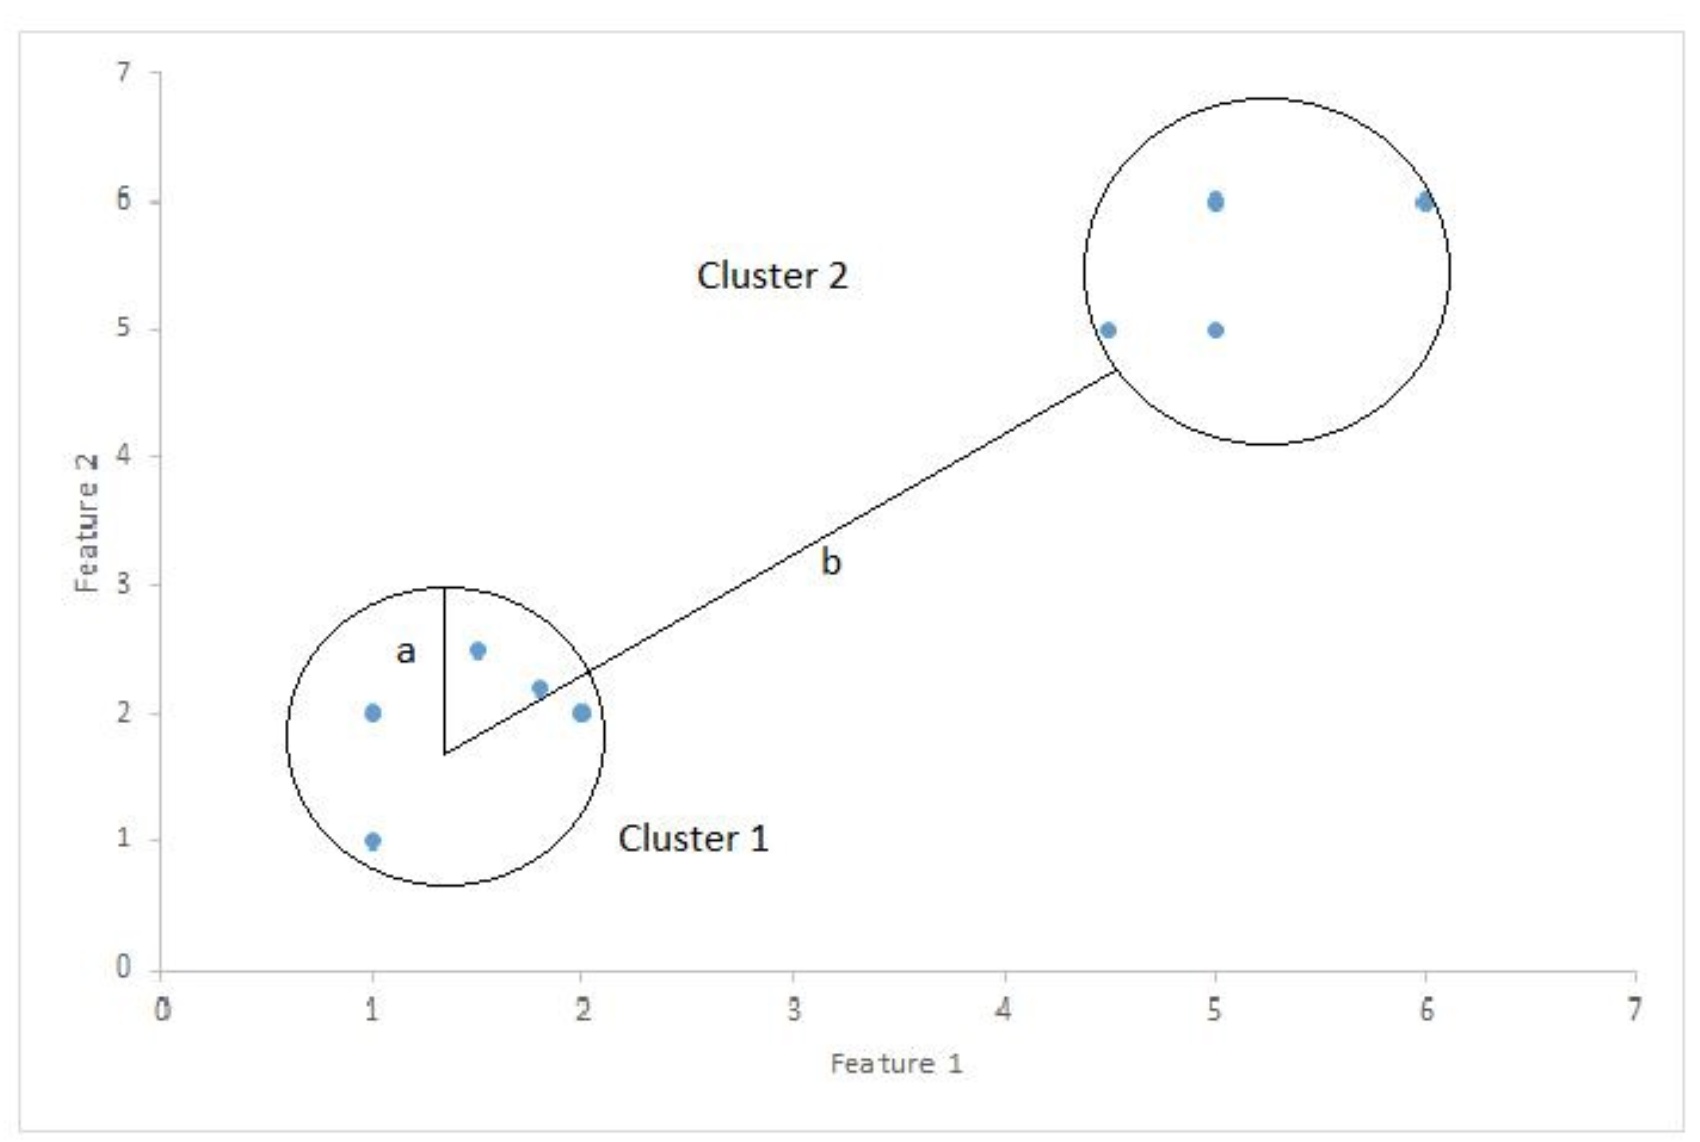

In [26]:
from sklearn.metrics import silhouette_score
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

# create a list of hypothetical scenarios fo different number of clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(mydata_z) for k in range(1,10,1)]

silhouette_scores = [silhouette_score(mydata_z, final_model.labels_)
                    for final_model in kmeans_per_k[1:]]
silhouette_scores

[0.41842496663215445,
 0.5157182558881063,
 0.3556670619372605,
 0.2726898791817692,
 0.2555645280295032,
 0.24839846123470524,
 0.2272530484628753,
 0.2260668172542118]

### Applying KMeans Clustering with 3 clusters based on the Elbow Plot above:

In [27]:
KMean= KMeans(n_clusters=3, init = 'k-means++', random_state = 42)
KMean.fit(mydata_z)
label=KMean.predict(mydata_z)

In [28]:
print(f'Silhouette Score(n=3): {silhouette_score(mydata_z, label)}')

Silhouette Score(n=3): 0.5157182558881063


We can say that the clusters are apart from each other but not signigicantly high as the silhouette score is nearer to the mid-way point between 0 and 1.

To check whether our silhouette score is providing the right information or not let’s create plot showing labelled data points.

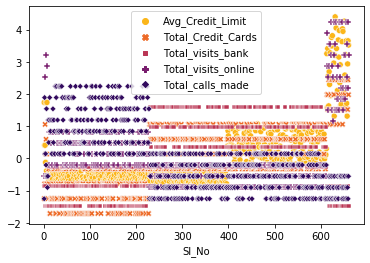

In [29]:
sns.scatterplot(data = mydata_z, palette='inferno_r')

Hard to tell, but definitely I can see 3 distinct blocks of data that show some form of separation

### A graphical way to view silohouette scores and the number of clusters = 3

**3 clusters are chosen with this plot**

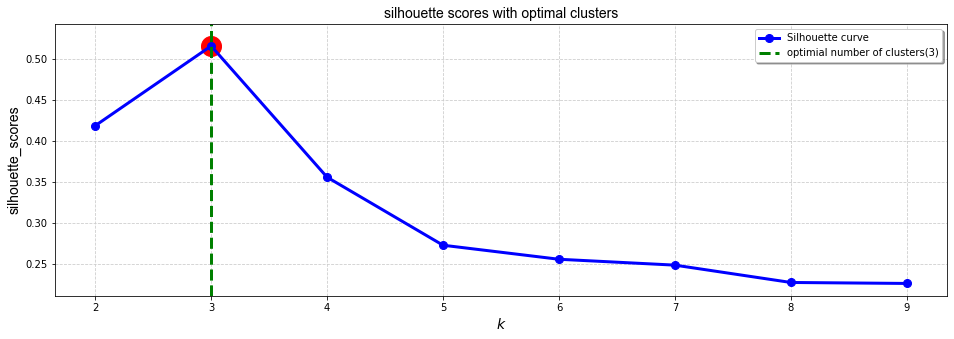

In [30]:
from pylab import rcParams

rcParams['figure.figsize'] = 16,5
_ = plt.plot(range(2, 10), silhouette_scores, "bo-", color='blue', linewidth=3, markersize=8, label='Silhouette curve')
_ = plt.xlabel("$k$", fontsize=14, family='Arial')
_ = plt.ylabel("silhouette_scores", fontsize=14, family='Arial')
_ = plt.grid(which='major', color='#cccccc', linestyle='--')

_ = plt.title("silhouette scores with optimal clusters", fontsize=14, family='Arial')

#calculate the optimal number of cluster
k = np.argmax(silhouette_scores) + 2

#Draw a vertical line to mark optimal number of clusters
_ = plt.axvline(x=k, linestyle='--', c='green', linewidth=3, markersize=8, label='optimial number of clusters({})'.format(k))

_ = plt.scatter(k, silhouette_scores[k-2], c='red', s=400)

_ = plt.legend(shadow=True)

_ = plt.show()

#### Let’s try with 4 clusters:

In [31]:
from sklearn.metrics import silhouette_score
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

# create a list of hypothetical scenarios for different number of clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(mydata_z) for k in range(1,10,1)]

silhouette_scores = [silhouette_score(mydata_z, final_model.labels_)
                    for final_model in kmeans_per_k[1:]]
silhouette_scores

[0.41842496663215445,
 0.5157182558881063,
 0.3556670619372605,
 0.2726898791817692,
 0.2555645280295032,
 0.24839846123470524,
 0.2272530484628753,
 0.2260668172542118]

In [32]:
KMean= KMeans(n_clusters=4, init = 'k-means++', random_state = 42)
KMean.fit(mydata_z)
label=KMean.predict(mydata_z)

In [33]:
print(f'Silhouette Score(n=4): {silhouette_score(mydata_z, label)}')

Silhouette Score(n=4): 0.3556670619372605


The Silhouette Score for 4 clusters (0.35) is less than for 3 clusters (0.51), which means that the clusters are not as separatated for 4 as they are for 3 clusters. **So I would go for 3 clusters.**

To check whether our silhouette score is providing the right information or not let’s create another scatter plot showing labelled data points.

### Groupring the clusters for box plot analysis

Initialise with 'K-means++' parameter to prevent the random initialization trap

random state to seed the algorithm to fix the same starting point every time so we don't get different results every time we run the code.

Going to split all our customers into 3 groups, i.e., 3 clusters, so we can quickly identify them. Each group are grouped by similiarites (similar information in each group)

The KMeans algorithm has a predict method that not only trains the model on the dataset but returns the n clusters, here it is 3.

In [34]:
# Let us first start with K = 3
final_model = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
final_model.fit(mydata_z)
prediction = final_model.predict(mydata_z)

#Append the prediction 
mydata["GROUP"] = prediction
mydata_z["GROUP"] = prediction
print("Groups Assigned into 3 clusters in the 'GROUP' column: \n")
mydata_z.head(10)

Groups Assigned into 3 clusters in the 'GROUP' column: 



,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
Sl_No,,,,,,
1,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
2,0.410293,-0.787585,-1.473731,2.520519,1.891859,1
3,0.410293,1.058973,-0.860451,0.134290,0.145528,0
4,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
5,1.740187,0.597334,-1.473731,3.202298,-0.203739,2
6,-0.387644,-0.787585,-1.473731,-0.547490,1.542593,1
7,1.740187,0.135694,-1.473731,2.861408,-0.553005,2
8,-0.520633,-0.787585,-1.473731,-0.547490,-0.902271,1
9,-0.786612,-1.249225,-1.473731,-0.206600,-0.553005,1


We have only printed the first five customers with the head() function and they are as follows:

Customer SI_No 1 belongs to cluster '0' <br>
Customer SI_No 2 belongs to cluster '1' <br>
Customer SI_No 3 belongs to cluster '0' <br>
Customer SI_No 4 belongs to cluster '0' <br>
Customer SI_No 5 belongs to cluster '2' <br>

.... and so on

Below is the array of all the groups, which exactely matches the above 'GROUP' coloum

In [35]:
print(prediction)

[0 1 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

### Grouping to make sense of clusters where k = 3

Below we see the average values for each feature in each cluster, the final row of the dataframe is the mean value for each column (we can use this to determine how big of a step each of these means is from one another).

If we look at the data we see that there is a group which prefers online interactions with their bank, they have a much higher credit limit and also have more credit cards. The customers who prefer in-person interactions tend to have the least number of credit cards and the lowest credit limit. The customers who contact via phonecall are in the middle.

One additional observation is that if we tally up the number of interactions per group (how many times they have used online, phone, or in-person services) we see the in-person customers appear to be the most active. 

**Note:**And we shall use these groupings going forward throughout the modelling process.

In [36]:
mydataClust = mydata_z.groupby(['GROUP'])
mydataClust.mean()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
GROUP,,,,,
0,-0.021062,0.373690,0.666395,-0.553672,-0.553005
1,-0.595796,-1.059623,-0.901518,0.322997,1.148109
2,2.831764,1.862226,-1.105763,2.827319,-0.874330


In [37]:
mydataClust = mydata_z.groupby(['GROUP']).mean().append(pd.DataFrame(mydata.std()).T)
mydataClust.index=['Offline','Online', 'In Person','Mean']
mydataClust

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,GROUP
Offline,-0.021062,0.373690,0.666395,-0.553672,-0.553005,NaN
Online,-0.595796,-1.059623,-0.901518,0.322997,1.148109,NaN
In Person,2.831764,1.862226,-1.105763,2.827319,-0.874330,NaN
Mean,37625.487804,2.167835,1.631813,2.935724,2.865317,0.634068


### Box plot analysis

Another way to understand the clusters is to produce boxplots for each variable within each cluster.

What we're trying to find out is are the variables different or overlapping.

You might be able to see the same patterns emerging! For example, Cluster 2 is strong on **Avg_Credit_Limit** and **Total_visits_online**! Other than that, nothing else seems to be correlated.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b1cc94910>,
      dtype=object)

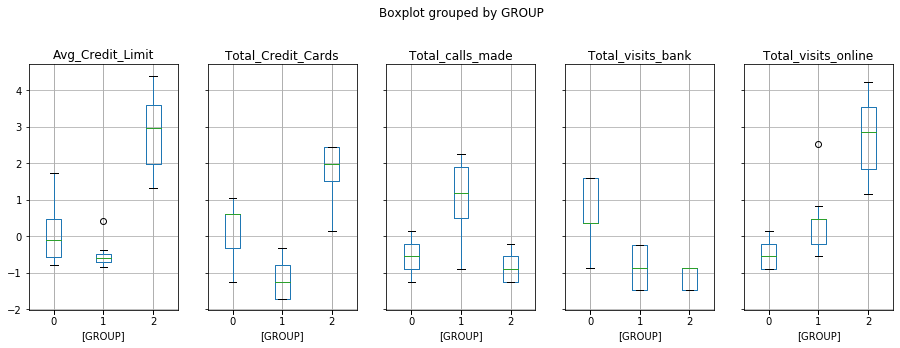

In [38]:
# mydata_z.boxplot(by='GROUP', layout = (2,3),figsize=(20,15))
# mydata_z.boxplot(by = 'GROUP', layout=(2,4), figsize=(20,15))
mydata_z.boxplot(by="GROUP", figsize=(15,10), layout=(2,5))

**correlation coefficient**

To determine if a relationship exists between Avg_Credit_Limit and Total_visits_online. You'll be able to see this where the cluster Group feature overlaps or shows similarity

In [39]:
mydata_z['Avg_Credit_Limit'].corr(mydata_z['Total_visits_online'])

0.5513845236894898

The correlationa coefficient above indicates that in **cluster 2 (GROUP 2)** where the relationship between **Avg_Credit_Limit**, **Total_Credit_Cards** and **Total_visits_online** at a moderate and positive level. This means that we can see a clear relationship between them, although the relationship is not perfect. The fact that the correlation coefficient is positive, indicates that higher levels of **Avg_Credit_Limit** is associated with higher **Total_visits_online**.


**But we must remember that correlation does not imply causation!**

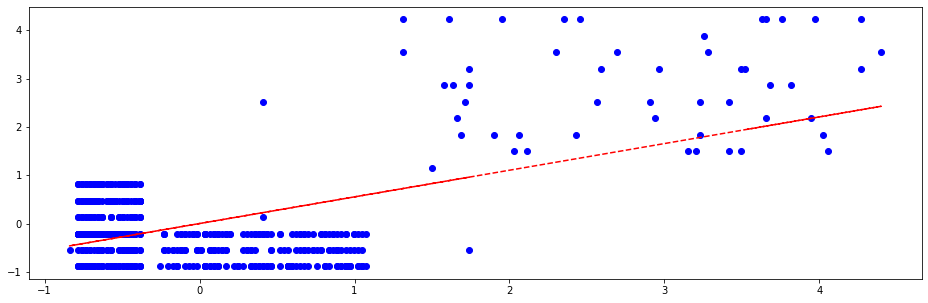

In [40]:
plt.plot(mydata_z['Avg_Credit_Limit'], mydata_z['Total_visits_online'], 'bo')
z = np.polyfit(mydata_z['Avg_Credit_Limit'], mydata_z['Total_visits_online'],1)
p = np.poly1d(z)
plt.plot(mydata_z['Avg_Credit_Limit'], p(mydata_z['Avg_Credit_Limit']), "r--")

As you can see from the above graphic, although the data does not form a perfectly straight line, but the data point following in a linear fashion and does fall in a way that indicates a positive relationship. Therefore, we can once again conclude that there is a relationship between Avg_Credit_Limit and Total_visits_online. It is important to note, however, that correlation does not in any way indicate causality and is merely indicative of a relationship between the two.

## 2)
## Hierarchical clustering (using different linkages) with the help of dendrogram and cophenetic coeff.

The hierarchical Clustering technique differs from K Means or K Mode, where the underlying algorithm of how the clustering mechanism works is different. K Means relies on a combination of centroid and euclidean distance to form clusters, hierarchical clustering on the other hand uses agglomerative or divisive techniques to perform clustering. 

Hierarchical clustering allows visualization of clusters using dendrograms that can help in better interpretation of results through meaningful taxonomies. Creating a dendrogram doesn’t require us to specify the number of clusters upfront.


The objective here is to:

- Determine the best linkage strategy for a dataset by creating clusters and evaluating the results

- Create and interpret a dendrogram while using Hierarchical clustering to determine the optimal number of clusters

- In a dendrogram, the y-axis marks the distance at which the clusters merge, while the objects are placed along the x-axis.

Hierarchical clustering method is based on hierarchy representation of clusters where parent cluster node is connected to further to child cluster node. A node represents collection of data points to one cluster. It is further divided into two types:

- Agglomerative Clustering
- Divisive Clustering

The **Agglomerative clustering** is the most popular and common hierarchical clustering also known as Agglomerative Nesting (AGNES). The methods starts by considering each data point as a single cluster. In the next step the singleton clusters are merged into a bog cluster based on the similarity between them. The procedure is repeated until all the datapoints are merged into one big cluster. The procedure can be represented as hierarchy/tree of clusters.


The **Divisive clustering** works completely opposite to agglomerative clustering and also known as Divisive Analysis (DIANA). The method starts from one big cluster considering all data points within it. In the next the big cluster is divided into the most heterogeneous two clusters. The procedure is repeated until each data point is in its own cluster. Figure on the next page is describe the hierarchical clustering methods.
[source: https://www.datanovia.com/en/lessons/agglomerative-hierarchical-clustering/ ]


**Note-** It should be noted that agglomerative clustering is good choice to identify small sized clusters whereas divisive clustering is more effective in case of big size clusters.


In [41]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

In [42]:
linkage_model = []
silhouette_result = []
cophenetic_coeff_result = []
# Blanks list to store linkage name, silhouette score and cophenetic coeff

### Linkage

Linkage process merges two clusters into one cluster based on the distance or similarity between them. The similarity between two clusters is very important parameter for merging and dividing of cluster. Following methods are popularly used to calculate similarity between two clusters which we will use:

- a) Ward’s method or minimum variance method
- b) Maximum or complete linkage
- c) Minimum or single linkage
- d) Mean or average linkage

As mentioned above, the agglomerative clustering is good choice to identify small sized clusters and is the one I shall use throught due to small number of feature we have in the dataset. Using the **AgglomerativeClustering()** function.

### Distance Calculation

Distance between two or more clusters can be calculated using multiple approaches, the most popular being Euclidean Distance. However, other distance metrics like Minkowski, City Block, Hamming, Jaccard, Chebyshev, etc. can also be used with hierarchical clustering.

I have gone with the Euclidean Distance with the models below.

In [43]:
## removing the GROUP column that was used in KMeans
mydata.drop(columns=['GROUP'], axis=1, inplace=True)
mydata_z.drop(columns=['GROUP'], axis=1, inplace=True)

In [44]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score


links = ['ward', 'complete', 'average', 'single', 'weighted', 'centroid', 'median']
affs = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
        'cosine', 'dice', 'euclidean', 'hamming', 'jaccard',
        'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto',
        'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean']


for aff in affs:
    for link in links:
        if link == 'ward' and aff != 'euclidean':
            pass
        elif link == 'centroid' and aff != 'euclidean':
            pass
        elif link == 'median' and aff != 'euclidean':
            pass
        else:
            Z = linkage(mydata_z, metric=aff, method=link)
            c, coph_dists = cophenet(Z , pdist(mydata_z))
            if c > .75:
                print('affinity:',aff, ', link:',link,':', c)

affinity: braycurtis , link: single : 0.8502845518924395
affinity: canberra , link: single : 0.7566178713003985
affinity: chebyshev , link: complete : 0.8533474836336782
affinity: chebyshev , link: average : 0.8974159511838106
affinity: chebyshev , link: weighted : 0.8913624010768603
affinity: cityblock , link: complete : 0.8731477899179829
affinity: cityblock , link: average : 0.896329431104133
affinity: cityblock , link: weighted : 0.8825520731498188
affinity: euclidean , link: complete : 0.8599730607972423
affinity: euclidean , link: average : 0.8977080867389372
affinity: euclidean , link: weighted : 0.8861746814895477
affinity: euclidean , link: centroid : 0.8939385846326323
affinity: euclidean , link: median : 0.8893799537016724
affinity: mahalanobis , link: average : 0.8326994115042134
affinity: mahalanobis , link: weighted : 0.7805990615142516
affinity: minkowski , link: complete : 0.8599730607972423
affinity: minkowski , link: average : 0.8977080867389372
affinity: minkowski , 

### Dendrogram

A dendrogram is a pictorial way to visualize hierarchical clustering. 

It is used to represent the relationship between objects in a feature space. It is used to display the distance between each pair of sequentially merged objects in a feature space. Dendrograms are commonly used in studying the hierarchical clusters before deciding the number of clusters appropriate to the dataset. 

The distance at which two clusters combine is referred to as the dendrogram distance. 

The dendrogram distance is a measure of if two or more clusters are disjoint or can be combined to form one cluster together.


### Cophenetic Coefficient

Visually looking into every dendrogram to determine which clustering linkage works best is challenging and requires a lot of manual effort. To overcome this we introduce the concept of Cophenetic Coefficient.

Imagine two Clusters, A and B with points A₁, A₂, and A₃ in Cluster A and points B₁, B₂, and B₃ in cluster B. Now for these two clusters to be well-separated points A₁, A₂, and A₃ and points B₁, B₂, and B₃ should be far from each other as well. 

Cophenet index is a measure of the correlation between the distance of points in feature space and distance on the dendrogram. 

It usually takes all possible pairs of points in the data and calculates the euclidean distance between the points. (remains the same, irrespective of which linkage algorithm we chose). 

It then computes the dendrogram distance at which clusters A & B combines. If the distance between these points increases with the dendrogram distance between the clusters then the Cophenet index is closer to 1.

### Deciding the Number of Clusters

There are no statistical techniques to decide the number of clusters in hierarchical clustering, unlike a K Means algorithm that uses an elbow plot to determine the number of clusters. However, one common approach is to analyze the dendrogram and look for groups that combine at a higher dendrogram distance. We shall take a look at the example below with the various Linkages.

### The Four different Linkages below:

### a) Ward’s method or minimum variance method

The distance between two clusters is based on the similarity calculated as the sum of square of the of the distances 𝑥& 𝑎𝑛𝑑 𝑦F. This is very much similar to average method except it works on the sum of squares

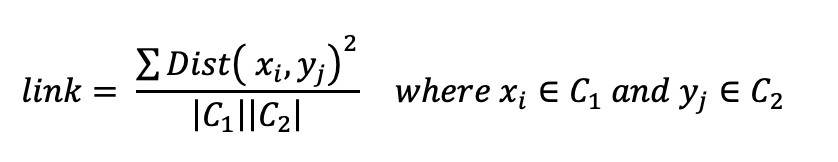

In [45]:
model = final_model
labels = model.labels_
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')
model.fit(mydata_z)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=3)

###  Visual representation of silhouette score and number of k = 3

**3 clusters are chosen with this plot**

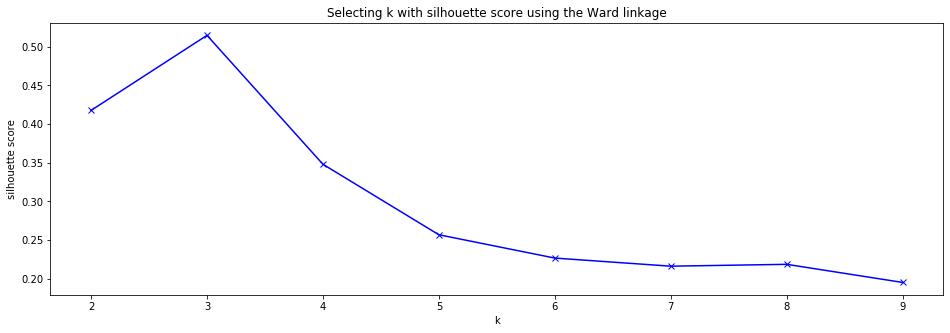

In [46]:
meanDistortions=[]

for k in range(2, 10):
    model=AgglomerativeClustering(n_clusters=k, affinity='euclidean',  linkage='ward')
    model.fit(mydata_z)
    prediction=model.labels_
    meanDistortions.append(silhouette_score(mydata_z, prediction))


plt.plot(range(2, 10), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Selecting k with silhouette score using the Ward linkage');

In [47]:
print('Ward’s method silhouette score', silhouette_score(mydata_z, prediction))

Ward’s method silhouette score 0.19527074669093417


**silhouette score** 0.54 good separation of clusters

Rememeber that the silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

**cophenet score**

- cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram

- closer it is to 1, the better is the clustering

- 0.77 is not bad

In [48]:
Z = linkage(mydata_z, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(mydata_z))

print('cophenet score:', c)

cophenet score: 0.7415156284827493


**Dendogram: Ward’s method**

Below illustrates the presence of **3 clusters** when the tree is cut at a Dendrogram distance of 30. The general idea being, all 3 groups of clusters combines at a much higher dendrogram distance and hence can be treated as individual groups for this analysis. We can also verify the same using a silhouette index score plot (above).

Code notes:<br>
- truncate_mode='lastp',  # show only the last p merged clusters
- p=15,  # show only the last p merged clusters

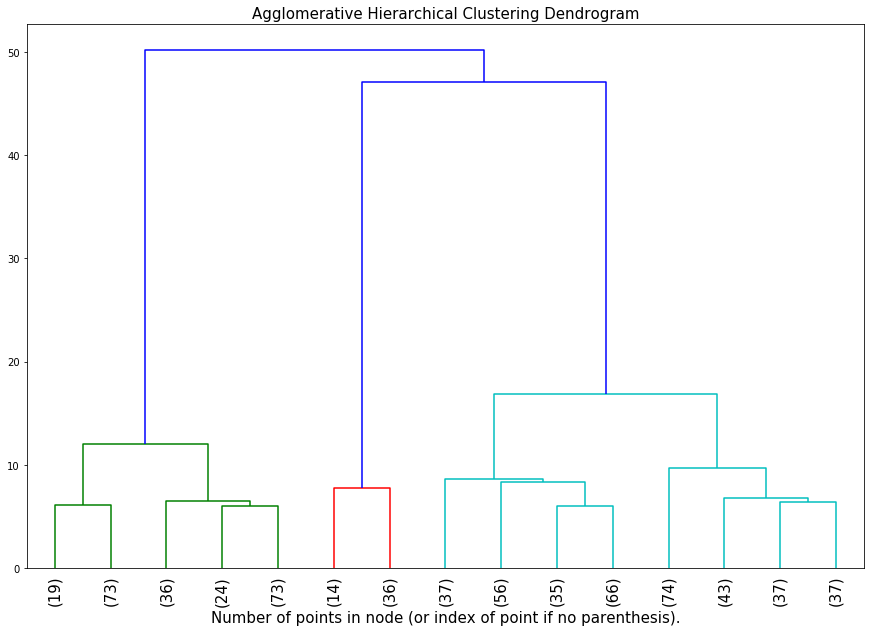

In [49]:
Z = linkage(mydata_z, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(mydata_z))
plt.figure(figsize=(15, 10))

plt.title('Agglomerative Hierarchical Clustering Dendrogram', fontsize=15)
plt.xlabel("Number of points in node (or index of point if no parenthesis).", fontsize=15)
dendrogram(Z, p=15, truncate_mode='lastp', leaf_rotation=90., leaf_font_size=15)
plt.show()

#### Grouping the clusters for boxplot analysis

In [50]:
model=AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')
model.fit(mydata_z)
preds=model.labels_
mydata['hc_grouping'] = preds
mydata_z['hc_grouping'] = preds

mydata.groupby('hc_grouping').count()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
hc_grouping,,,,,
0,385,385,385,385,385
1,225,225,225,225,225
2,50,50,50,50,50


Here we add the predictions to the unscaled data so that we can gain some real world interpretability. Segmenting the customers into three distinct groups:
- Offline
- Online
- In Person


In [51]:
mydataMean = mydata.groupby('hc_grouping').mean().append(pd.DataFrame(mydata.std()).T)
mydataMean.index=['Offline','Online', 'In Person', 'Mean']
mydataMean

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,hc_grouping
Offline,33851.948052,5.516883,3.493506,0.979221,1.994805,NaN
Online,12151.111111,2.422222,0.937778,3.546667,6.857778,NaN
In Person,141040.000000,8.740000,0.600000,10.900000,1.080000,NaN
Mean,37625.487804,2.167835,1.631813,2.935724,2.865317,0.634087


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b1eb91cd0>,
      dtype=object)

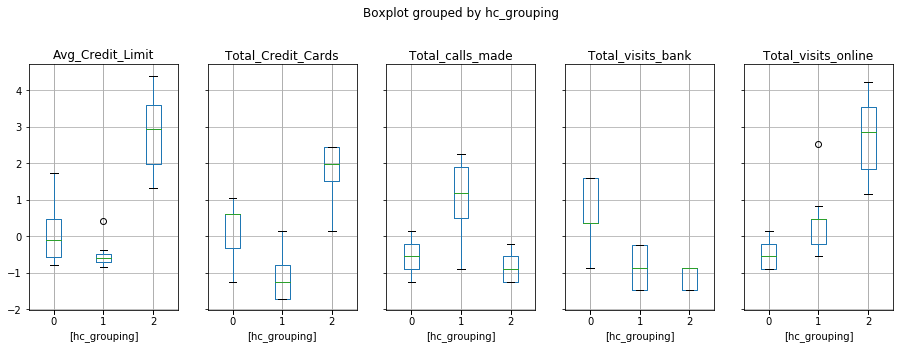

In [52]:
mydata_z.boxplot(by="hc_grouping", figsize=(15,10), layout=(2,5))

**correlation coefficient**

In cluster 2 (GROUP 2), the correlation between **Avg_Credit_Limit'** and **Total_visits_online** and between **Avg_Credit_Limit** and **Total_Credit_Cards** are strongest, but **Avg_Credit_Limit'** and **Total_visits_online** is the strongest. There averages are almost the same.

In [53]:
print(mydata_z['Avg_Credit_Limit'].corr(mydata_z['Total_visits_online']))
print(mydata_z['Avg_Credit_Limit'].corr(mydata_z['Total_Credit_Cards']))
print(mydata_z['Total_visits_online'].corr(mydata_z['Total_Credit_Cards']))

0.5513845236894898
0.6088604935524965
0.16775829968144565


The correlationa coefficient above indicates that the relationship between **Avg_Credit_Limit** and **Total_Credit_Cards** is higher than moderate and positive level. This means that we can see a clear relationship between **Avg_Credit_Limit** and **Total_Credit_Cards**.

Below, we are able to draw a line through the scatter plot with an upward trend with the data point following in a linear fashion. Although the relationship is not perfect. The fact that the correlation coefficient is positive, indicates that higher levels of **Avg_Credit_Limit** is associated with higher **Total_visits_online**.

**But we must remember that correlation does not imply causation!**

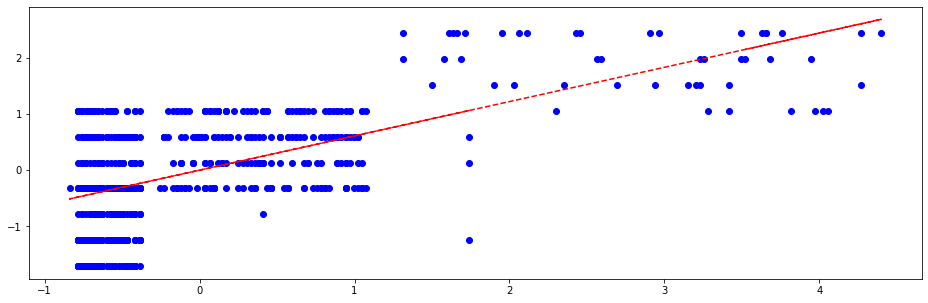

In [54]:
plt.plot(mydata_z['Avg_Credit_Limit'], mydata_z['Total_Credit_Cards'], 'bo')
z = np.polyfit(mydata_z['Avg_Credit_Limit'], mydata_z['Total_Credit_Cards'],1)
p = np.poly1d(z)
plt.plot(mydata_z['Avg_Credit_Limit'], p(mydata_z['Avg_Credit_Limit']), "r--")


In [55]:
linkage_model.append(model.linkage)
silhouette_result.append(silhouette_score(mydata_z, prediction))
cophenetic_coeff_result.append(c)

### b) Maximum or complete linkage

Maximum linkage between two clusters is defined as the maximum distance between all pairs of points within two clusters. This can be written as:

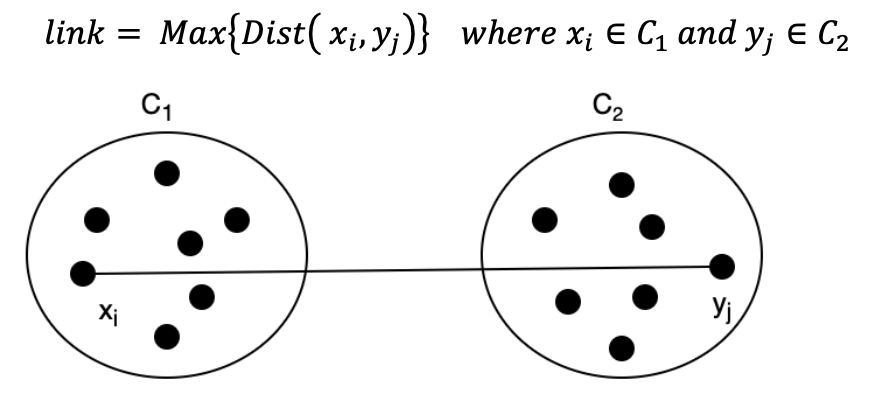

In [56]:
labels = model.labels_
silhouette_score(mydata_z, labels, metric='euclidean')
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='complete')
model.fit(mydata_z)
# silhouette_score(mydata_z, labels, metric='euclidean')

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=3)

**2 clusters are chosen with this plot**

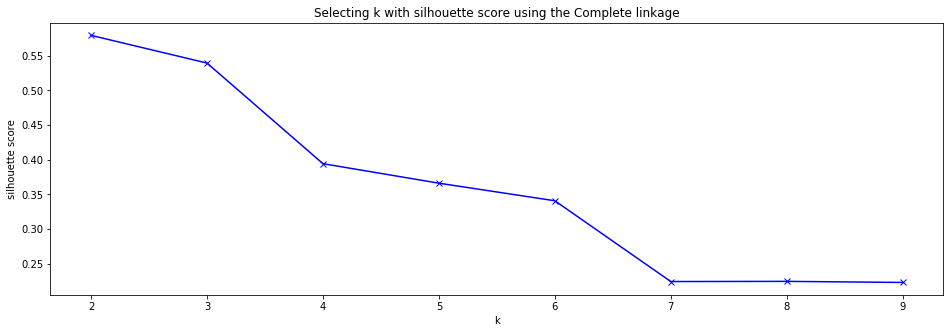

In [57]:
meanDistortions=[]

for k in range(2, 10):
    model=AgglomerativeClustering(n_clusters=k, affinity='euclidean',  linkage='complete')
    model.fit(mydata_z)
    prediction=model.labels_
    meanDistortions.append(silhouette_score(mydata_z, prediction))


plt.plot(range(2, 10), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Selecting k with silhouette score using the Complete linkage');

In [58]:
print('silhouette score', silhouette_score(mydata_z, prediction))

silhouette score 0.2231727883254364


**Dendogram: Maximum or complete linkage**

If you drew a horizontal line across the 7 mark it will cut across 2 vertical lines, thus **2 clusters** capturing all the other groupings, hence 2 clusters are chosen based on this method. This also matches the above Selecting k with silhouette score using the Complete linkage plot

It's not a method that is set in stone, but one can take the longest line that doesn't cross any other line and take that as the threshold. Here it would be **3 clusters** if we set threshold to 5 and drew a horizontal line across

The numbers at the bottom in brackets show how many data points were in that cluster.


Code notes:<br>
- truncate_mode='lastp',  # show only the last p merged clusters
- p=15,  # show only the last p merged clusters

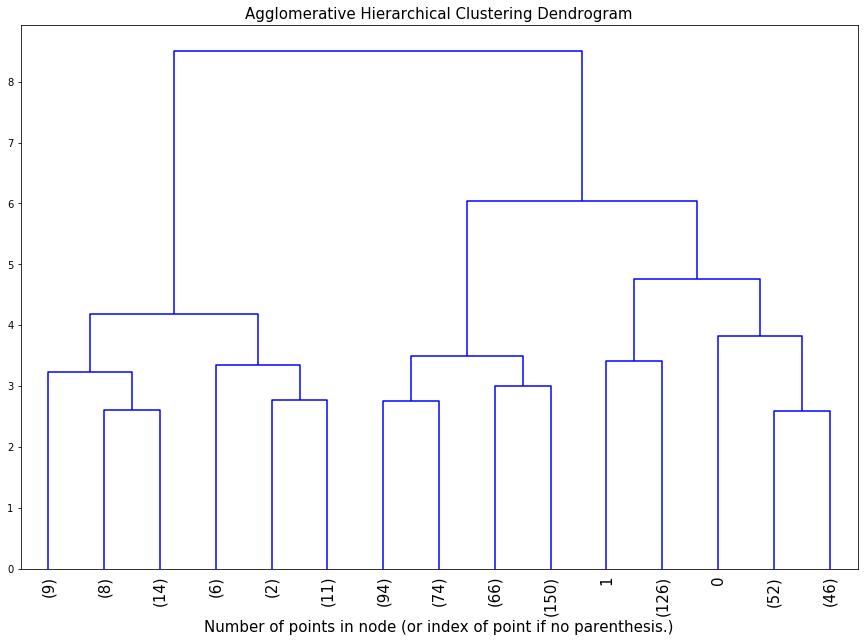

In [59]:
Z = linkage(mydata_z, metric='euclidean', method='complete')
c, coph_dists = cophenet(Z , pdist(mydata_z))
plt.figure(figsize=(15, 10))

plt.title('Agglomerative Hierarchical Clustering Dendrogram', fontsize=15)
plt.xlabel('Number of points in node (or index of point if no parenthesis.)', fontsize=15)
dendrogram(Z, p=15, truncate_mode='lastp', leaf_rotation=90.,color_threshold = 0, leaf_font_size=15)
plt.show()

**cophenet score**

- cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram

- closer it is to 1, the better is the clustering

- 0.89 is very good

In [60]:
Z = linkage(mydata_z, metric='euclidean', method='complete')
c, coph_dists = cophenet(Z , pdist(mydata_z))

print('cophenet score', c)

cophenet score 0.8856273614571176


In [61]:
model=AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='complete')
model.fit(mydata_z)
preds=model.labels_
mydata['hc_grouping'] = preds
mydata_z['hc_grouping'] = preds

mydata.groupby('hc_grouping').count()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
hc_grouping,,,,,
0,610,610,610,610,610
1,50,50,50,50,50


Here we add the predictions to the unscaled data so that we can gain some real world interpretability. Segmenting the customers into three distinct groups:
- Offline
- Online

In [62]:
mydataMean = mydata.groupby('hc_grouping').mean().append(pd.DataFrame(mydata.std()).T)
mydataMean.index=['Offline','Online', 'Mean']
mydataMean

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,hc_grouping
Offline,25847.540984,4.375410,2.550820,1.926230,3.788525,NaN
Online,141040.000000,8.740000,0.600000,10.900000,1.080000,NaN
Mean,37625.487804,2.167835,1.631813,2.935724,2.865317,0.264811


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b1fcad950>,
      dtype=object)

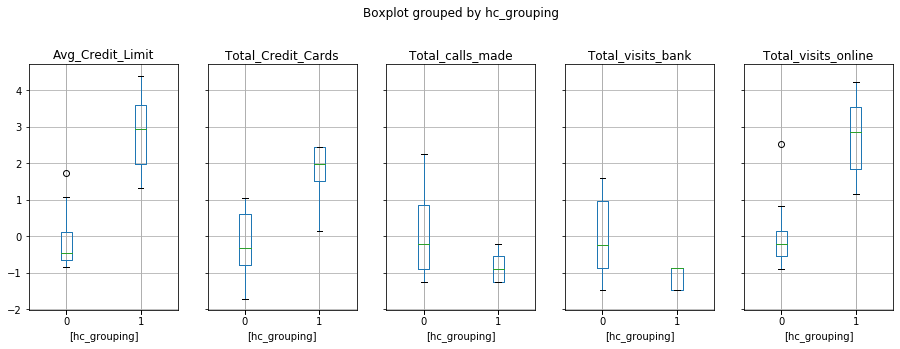

In [63]:
mydata_z.boxplot(by="hc_grouping", figsize=(15,10), layout=(2,5))

**correlation coefficient**

The correlation coefficient in **cluster 2 (GROUP 2)** above indicates that the relationship between **Avg_Credit_Limit**, **Total_visits_online**  and **Total_Credit_Cards** is higher than moderate and positive level.

Below, we are able to draw a line through the scatter plot with an upward trend with the data point following in a linear fashion. Although the relationship is not perfect. The fact that the correlation coefficient is positive, indicates that higher levels of **Avg_Credit_Limit** is associated with higher **Total_Credit_Cards**.

The correlation between **Avg_Credit_Limit'** and **Total_visits_online** and between **Avg_Credit_Limit** and **Total_Credit_Cards** are the strongest

**But we must remember that correlation does not imply causation!**

In [64]:
print(mydata_z['Avg_Credit_Limit'].corr(mydata_z['Total_visits_online']))
print(mydata_z['Avg_Credit_Limit'].corr(mydata_z['Total_Credit_Cards']))
print(mydata_z['Total_visits_online'].corr(mydata_z['Total_Credit_Cards']))

0.5513845236894898
0.6088604935524965
0.16775829968144565


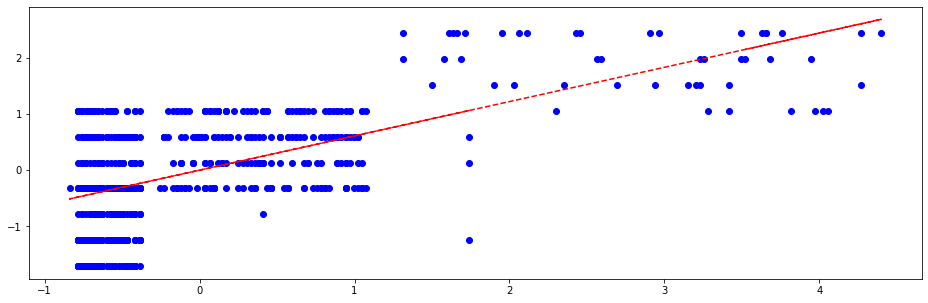

In [65]:
plt.plot(mydata_z['Avg_Credit_Limit'], mydata_z['Total_Credit_Cards'], 'bo')
z = np.polyfit(mydata_z['Avg_Credit_Limit'], mydata_z['Total_Credit_Cards'],1)
p = np.poly1d(z)
plt.plot(mydata_z['Avg_Credit_Limit'], p(mydata_z['Avg_Credit_Limit']), "r--")

In [66]:
linkage_model.append(model.linkage)
silhouette_result.append(silhouette_score(mydata_z, prediction))
cophenetic_coeff_result.append(c)

### c) Minimum or single linkage

Minimum linkage between two clusters is defined as the minimum distance between all pairs of points within two clusters. This can be written as:

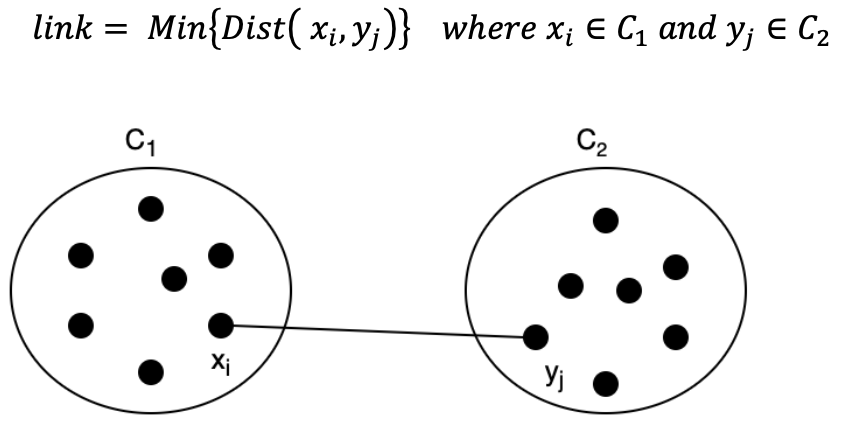

In [67]:
labels = model.labels_
silhouette_score(mydata_z, labels, metric='euclidean')
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='single')
model.fit(mydata_z)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='single', memory=None, n_clusters=3)

**2 clusters are chosen with this plot**

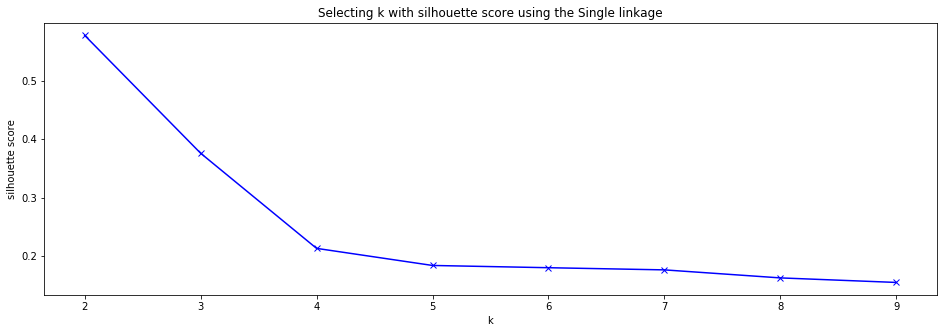

In [68]:
meanDistortions=[]

for k in range(2, 10):
    model=AgglomerativeClustering(n_clusters=k, affinity='euclidean',  linkage='single')
    model.fit(mydata_z)
    prediction=model.labels_
    meanDistortions.append(silhouette_score(mydata_z, prediction))


plt.plot(range(2, 10), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Selecting k with silhouette score using the Single linkage');

In [69]:
print('silhouette score', silhouette_score(mydata_z, prediction))

silhouette score 0.15462677733907093


**Dendogram: Minimum or single linkage**

Drawing a horizontal line fom 2.0 we find **2 clusters** that groups a higher dendrogram distance encapsulating all the other clusters.

Code notes:<br>
- truncate_mode='lastp',  # show only the last p merged clusters
- p=15,  # show only the last p merged clusters

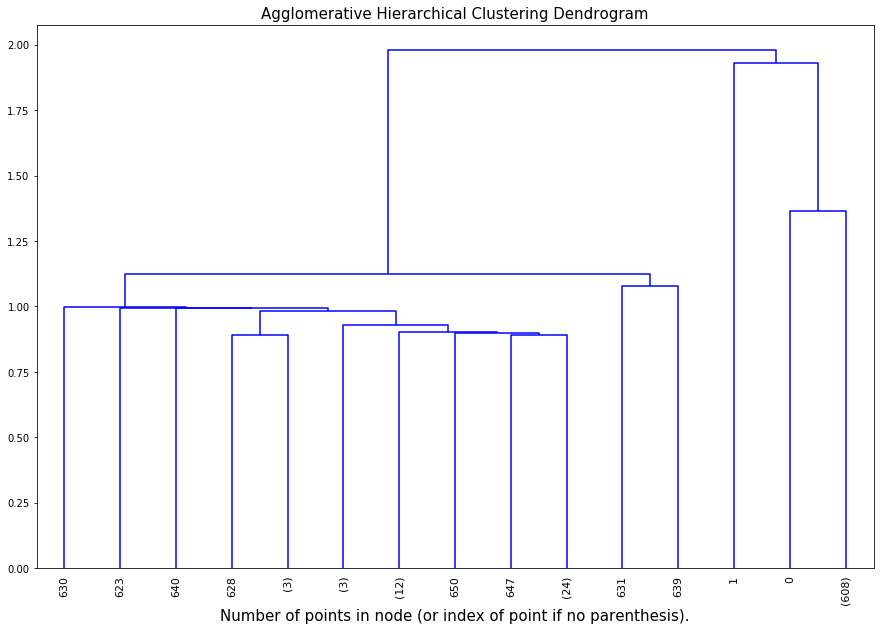

In [70]:
Z = linkage(mydata_z, metric='euclidean', method='single')
c, coph_dists = cophenet(Z , pdist(mydata_z))
plt.figure(figsize=(15, 10))

plt.title('Agglomerative Hierarchical Clustering Dendrogram', fontsize=15)
plt.xlabel("Number of points in node (or index of point if no parenthesis).", fontsize=15)
dendrogram(Z, p=15, truncate_mode='lastp', leaf_rotation=90.,color_threshold = 0, leaf_font_size=11)
plt.show()

**cophenet score**

- cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram

- closer it is to 1, the better is the clustering

- 0.74 is very good

In [71]:
Z = linkage(mydata_z, metric='euclidean', method='single')
c, coph_dists = cophenet(Z , pdist(mydata_z))

print('cophenet score', c)

cophenet score 0.7495170432379031


In [72]:
model=AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='single')
model.fit(mydata_z)
preds=model.labels_
mydata['hc_grouping'] = preds
mydata_z['hc_grouping'] = preds

mydata.groupby('hc_grouping').count()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
hc_grouping,,,,,
0,610,610,610,610,610
1,50,50,50,50,50


Here we add the predictions to the unscaled data so that we can gain some real world interpretability. Segmenting the customers into three distinct groups:
- Offline
- Online

In [73]:
mydataMean = mydata.groupby('hc_grouping').mean().append(pd.DataFrame(mydata.std()).T)
mydataMean.index=['Offline','Online','mean']
mydataMean

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,hc_grouping
Offline,25847.540984,4.375410,2.550820,1.926230,3.788525,NaN
Online,141040.000000,8.740000,0.600000,10.900000,1.080000,NaN
mean,37625.487804,2.167835,1.631813,2.935724,2.865317,0.264811


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b1c1ffc50>,
      dtype=object)

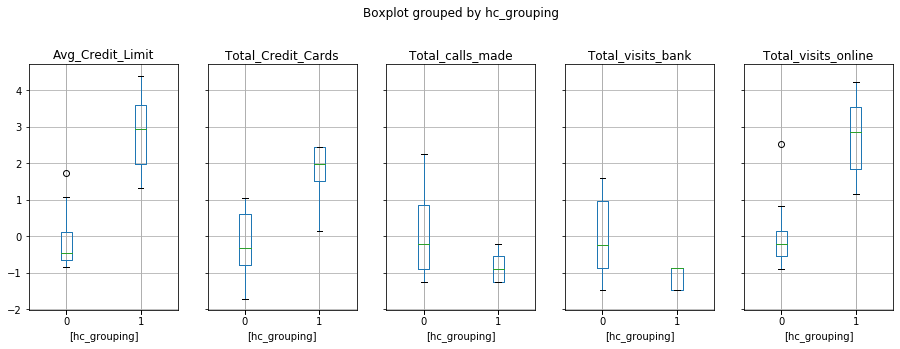

In [74]:
mydata_z.boxplot(by="hc_grouping", figsize=(15,10), layout=(2,5))

**correlation coefficient**

The correlation coefficient in **cluster 2 (GROUP 2)** above indicates that the relationship between 
**Avg_Credit_Limit** and **Total_visits_online** is higher than moderate and positive level.

Below, we are able to draw a line through the scatter plot with an upward trend with the data point following in a linear fashion. Although the relationship is not perfect. The fact that the correlation coefficient is positive, indicates that higher levels of **Avg_Credit_Limit** is associated with higher **Total_visits_online**.

The correlation between **Avg_Credit_Limit'** and **Total_visits_online** and between **Avg_Credit_Limit** and **Total_Credit_Cards** are the strongest

**But we must remember that correlation does not imply causation!**

In [75]:
print(mydata_z['Avg_Credit_Limit'].corr(mydata_z['Total_visits_online']))
print(mydata_z['Avg_Credit_Limit'].corr(mydata_z['Total_Credit_Cards']))
print(mydata_z['Total_visits_online'].corr(mydata_z['Total_Credit_Cards']))

0.5513845236894898
0.6088604935524965
0.16775829968144565


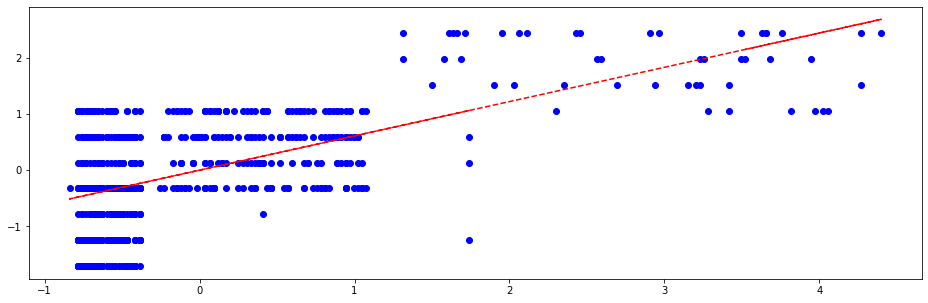

In [76]:
plt.plot(mydata_z['Avg_Credit_Limit'], mydata_z['Total_Credit_Cards'], 'bo')
z = np.polyfit(mydata_z['Avg_Credit_Limit'], mydata_z['Total_Credit_Cards'],1)
p = np.poly1d(z)
plt.plot(mydata_z['Avg_Credit_Limit'], p(mydata_z['Avg_Credit_Limit']), "r--")

In [77]:
linkage_model.append(model.linkage)
silhouette_result.append(silhouette_score(mydata_z, prediction))
cophenetic_coeff_result.append(c)

### d) Mean or average linkage

The distance between two clusters is calculated by taking mean of similarity among all pair of points.

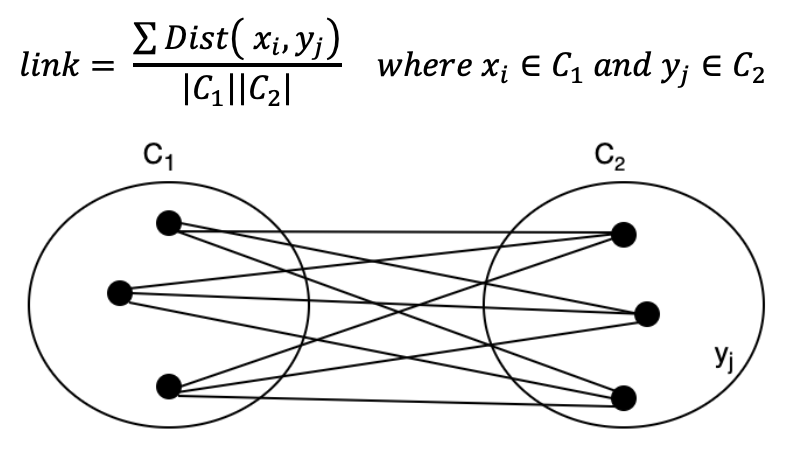

In [78]:
labels = model.labels_
silhouette_score(mydata_z, labels, metric='euclidean')
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
model.fit(mydata_z)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=3)

**2 clusters are choosen with this plot**

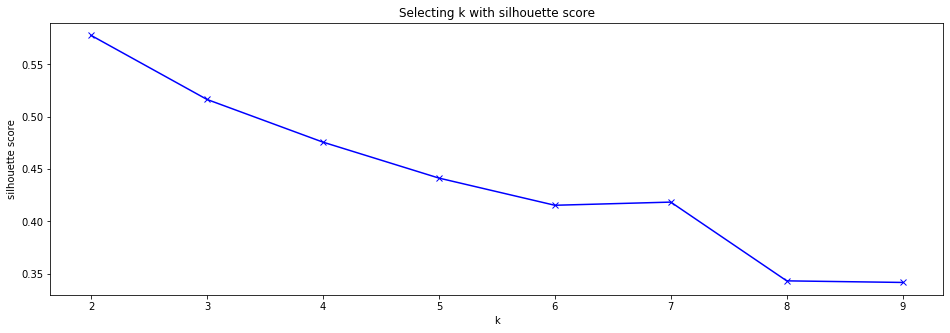

In [79]:
meanDistortions=[]

for k in range(2, 10):
    model=AgglomerativeClustering(n_clusters=k, affinity='euclidean',  linkage='average')
    model.fit(mydata_z)
    prediction=model.labels_
    meanDistortions.append(silhouette_score(mydata_z, prediction))


plt.plot(range(2, 10), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Selecting k with silhouette score');

In [80]:
print('silhouette score', silhouette_score(mydata_z, prediction))

silhouette score 0.3415486932890892


**Dendogram: Minimum or single linkage**

Drawing a horizontal line fom 4 we find **2 clusters** that groups a higher dendr
ogram distance encapsulating all the other clusters.

Code notes:<br>
- truncate_mode='lastp',  # show only the last p merged clusters
- p=15,  # show only the last p merged clusters

In [ ]:
linkage

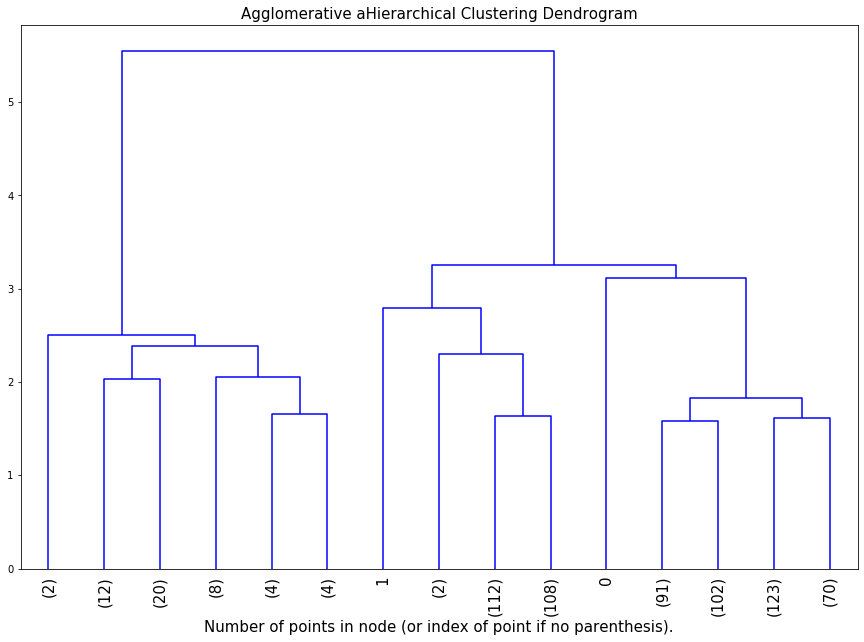

In [81]:
Z = linkage(mydata_z, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(mydata_z))
plt.figure(figsize=(15, 10))

plt.title('Agglomerative aHierarchical Clustering Dendrogram', fontsize=15)
plt.xlabel("Number of points in node (or index of point if no parenthesis).", fontsize=15)
dendrogram(Z, p=15, truncate_mode='lastp', leaf_rotation=90.,color_threshold = 0, leaf_font_size=15)
plt.show()

**cophenet score**

- cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram

- closer it is to 1, the better is the clustering

- 0.92 is the best cophenet score so far

In [82]:
Z = linkage(mydata_z, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(mydata_z))

print('cophenet score', c)

cophenet score 0.9020408482999265


In [83]:
# mydata.drop(columns=['GROUP'], axis=1, inplace=True)
# mydata_z.drop(columns=['GROUP'], axis=1, inplace=True)

In [84]:
model=AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='average')
model.fit(mydata_z)
preds=model.labels_
mydata['hc_grouping'] = preds
mydata_z['hc_grouping'] = preds

mydata.groupby('hc_grouping').count()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
hc_grouping,,,,,
0,610,610,610,610,610
1,50,50,50,50,50


In [85]:
mydataMean = mydata.groupby('hc_grouping').mean().append(pd.DataFrame(mydata.std()).T)
mydataMean.index=['Offline','Online', 'Mean']
mydataMean

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,hc_grouping
Offline,25847.540984,4.375410,2.550820,1.926230,3.788525,NaN
Online,141040.000000,8.740000,0.600000,10.900000,1.080000,NaN
Mean,37625.487804,2.167835,1.631813,2.935724,2.865317,0.264811


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b20ee9c50>,
      dtype=object)

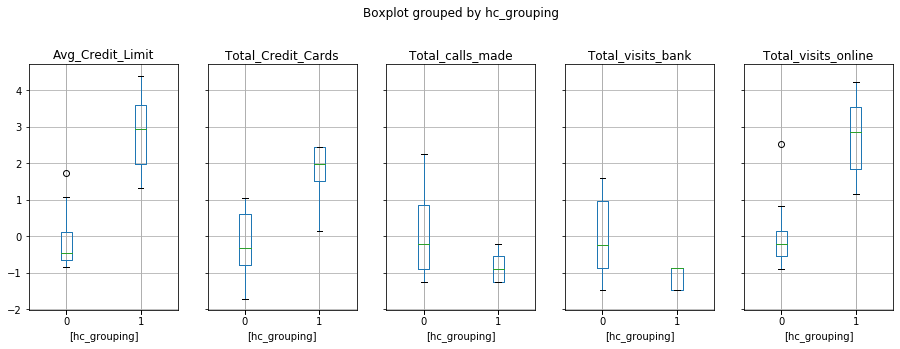

In [86]:
mydata_z.boxplot(by="hc_grouping", figsize=(15,10), layout=(2,5))

**correlation coefficient**

In the box plots, **cluster 2 (GROUP 2)** above indicates that there is relationship between **Avg_Credit_Limit**, **Total_visits_online**  and **Total_Credit_Cards** being higher than moderate and positive level as they are overlapping


In [87]:
print(mydata_z['Avg_Credit_Limit'].corr(mydata_z['Total_visits_online']))
print(mydata_z['Avg_Credit_Limit'].corr(mydata_z['Total_Credit_Cards']))
print(mydata_z['Total_visits_online'].corr(mydata_z['Total_Credit_Cards']))

0.5513845236894898
0.6088604935524965
0.16775829968144565


The correlation coefficient above indicates that the relationship between **Avg_Credit_Limit** and **Total_Credit_cards** show the strongest correlation.

**But we must remember that correlation does not imply causation!**


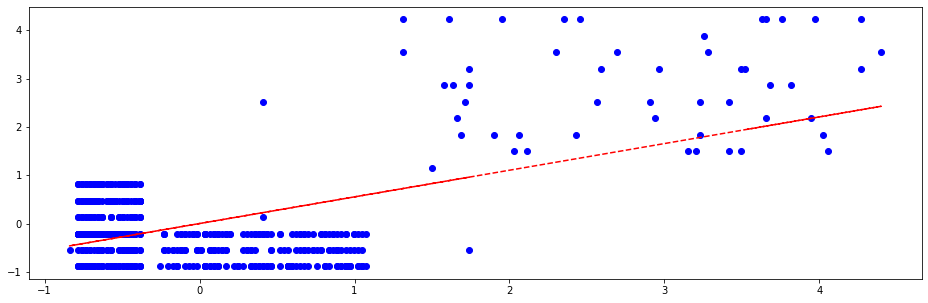

In [88]:
plt.plot(mydata_z['Avg_Credit_Limit'], mydata_z['Total_visits_online'], 'bo')
z = np.polyfit(mydata_z['Avg_Credit_Limit'], mydata_z['Total_visits_online'],1)
p = np.poly1d(z)
plt.plot(mydata_z['Avg_Credit_Limit'], p(mydata_z['Avg_Credit_Limit']), "r--")

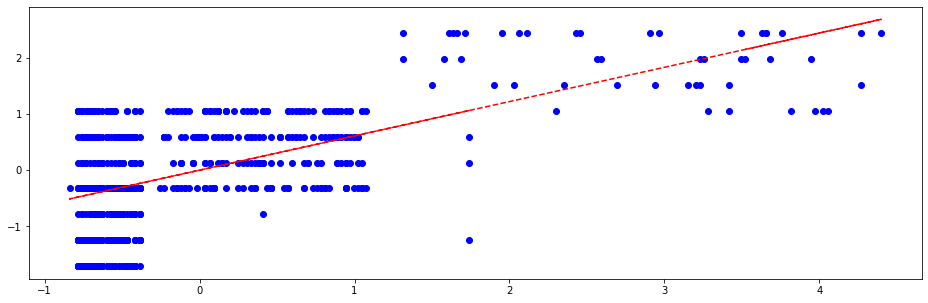

In [89]:
plt.plot(mydata_z['Avg_Credit_Limit'], mydata_z['Total_Credit_Cards'], 'bo')
z = np.polyfit(mydata_z['Avg_Credit_Limit'], mydata_z['Total_Credit_Cards'],1)
p = np.poly1d(z)
plt.plot(mydata_z['Avg_Credit_Limit'], p(mydata_z['Avg_Credit_Limit']), "r--")

Both are showing a positive linear relation between **Avg_Credit_Limit** and **Total_Credit_Cards**; and between **Avg_Credit_Limit** and **Total_visits_online**

In [90]:
linkage_model.append(model.linkage)
silhouette_result.append(silhouette_score(mydata_z, prediction))
cophenetic_coeff_result.append(c)

### DataFrame to compare Hierarchical clustering results

In [91]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

In [92]:
results = pd.DataFrame()
results['Linkage:'] = linkage_model
results['Silhouette score'] = silhouette_result
results['Ccophenetic coeff'] = cophenetic_coeff_result
results = results.set_index('Linkage:')
results

,Silhouette score,Ccophenetic coeff
Linkage:,,
ward,0.196968,0.741516
complete,0.221041,0.885627
single,0.154627,0.749517
average,0.341549,0.902041


We choose three clusters wich the linkage 'Ward' because it had the highest Silhouette Score of 0.34 with a the highest Ccophenetic coeff of 0.90

In [93]:
print('The optimal number of cluster for the given data is {}.'.format(k))

The optimal number of cluster for the given data is 9.


## Conclusion

Just to recap how the clusters were formed. 

In k-means clustering analysis we used a pre-specified no. of cluster selected by subjectively assessing the bend in the 'elbow method'. Whereas in Hierarchical clustering we  build a hierarchy of clusters without having fixed number of cluster.

Then we used the Silouhette score to help us decide how how similar an observation to its own cluster compared to that of other clusters and the closer to 1 was the best. In addition we used box plots to give us a visual as to which groups showed a strong overlap of the features so as to draw correlations.

With Hierarchical clustering we looked at the different linkages with the help of dendrogram and cophenetic coeff as well as the Silouhette score and boxplots. 

#### KMeans

We selected k = 3 because of the Silhouette Score being 0.51 compared to K = 3 where the Silhouette Score 0.35 was much lower.

#### Hierarchical clustering 

We chose three clusters wich the linkage 'Ward' because it had the highest Silhouette Score of 0.34 with a the highest Ccophenetic coeff of 0.90



### How many different segments of customers are there?

I tried experimented with 3 and 4 KMeans clusters and tried different linkages with Hierarchical clusters and found that the optimum number of clusters that could explain the dataset was three. And after looking at the similiarites in each of these groups I have distinctly categorized these customers as:

- **In-person users:** prefer to handle bank transactions in person. They have the fewest credit cards and the lowest available credit. They are also the most active users.

- **Phone users:** prefer verbally handling transactions remotely.

- **Online users:** prefer digital transactions. They also have the most credit cards and the highest available credit.

### My recommendations to the bank on how to better market to and service these customers?

When it comes to marketing strategy, we can treat each of the three groups as different personas based on the levels of activity. 
- **Online users** would probably prefer emails/text notifications rather than letters for promotions. This gorup also hold the most credit cards and which could mean they are the best customers for ROI, they will spend more and pay us more interest!
- **Phone users:** there must be a reason why this group love using the phone a lot, and I would go back and further investigate the reasons why. It could be there was something they didn't understand on the website, it could be due to fraud alerts (tiebacks) when drawing money in a foreign country, etc. So I would not readily pass any judgement as to what marketing strategy to use here.
- **In-person users** might prefer letters to be informed about promotions. Especially, now, in light of the pandemic whereby high st branches are closed. Also, sending letters wastes time and money and is not good for the environment, therefore, I would spend more marketing on educating and encouraging them to go online. This will be more beneficial in the long-run. 

#### State vs Trait:¶

As we have seen from the EDA section, a customer's behaviour can change dramatically. A state is a characteristic that can change over time, for instance, a person can be illiterate as a state, but if they choose to overcome such a weakness they can change. A trait is something which is unchanging, for instance, if a person is left-handed they can try to learn to use their non-dominant hand but they won't be able to attain the same level of mastery with it as their dominant hand. (https://www.sparknotes.com/psychology/psych101/personality/section1/)

In the dataset there were five duplicate customers whom transitioned from one cluster to another, so nuturing a customer is possible, but also understanding why they changed could help the marketing team put forward the right incentives. Again, not enough data here to understand these individuals decided to evolve in their interactions witht the bank.